### Import

In [1]:
import joblib

# Preprocessing
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Torch-related
import torch
from pytorch_model_summary import summary

# Custom defined
from libs.raw_data import *
from libs.dataset import *
from architecture.architecture import *

device = torch.device("cuda")

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedba

# Config

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

class LogScaler(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        return np.log1p(x)

In [3]:
is_test_mode = False
mode = "pre-train"
# mode = "fine_tuning"

# Raw data
is_prep_data_exist = True

# Data loader
MAX_SEQ_LEN = 200
# MIN_MEANINGFUL_SEQ_LEN = int(MAX_SEQ_LEN*0.1)
MIN_MEANINGFUL_SEQ_LEN = 10

modality_info = {
    "group": ["article_id", "sales_channel_id"],
    "target": ["sales"],
    "temporal": ["price"],
    "img": ["img_path"],
    "nlp": []
}
processing_info = {
    "scaling_cols": {"sales": StandardScaler, "price": StandardScaler},
    "embedding_cols": [],
    "img_cols": ["img_path"],
    "nlp_cols": []
}

# Model
batch_size = 16
target_batch_size = 16
num_accm = int(target_batch_size//batch_size)
nhead = 6
dropout = 0.1
patch_size = 16

d_model = {"encoder":nhead*64, "decoder":nhead*32}
d_ff = {"encoder":nhead*64, "decoder":nhead*32}
num_layers = {"encoder":3, "decoder":3}
remain_rto = {"temporal":0.25, "img":0.25, "nlp":0.25}
# remain_rto = {"temporal":1., "img":1., "nlp":1.}


# Data

### Load data

In [4]:
data_info = DataInfo(modality_info, processing_info)
df_prep = get_raw_data(is_test_mode, is_prep_data_exist)

if mode == "pre-train":
    df_train = df_prep[(df_prep["meaningful_size"] >= MIN_MEANINGFUL_SEQ_LEN)
                        &(df_prep["time_idx"] <= MAX_SEQ_LEN-1)
                        &(~pd.isna(df_prep["detail_desc"]))]

In [5]:
pd.set_option("display.max_columns", None)
# display(df_train.head())
print(df_train["perceived_colour_value_name"].unique())
# df_train[df_train["perceived_colour_value_name"]=="Light"]
df_train = df_train[df_train["perceived_colour_value_name"].isin(["Light", "Bright"])]

['Dark' 'Light' 'Dusty Light' 'Medium Dusty' 'Bright' 'Medium' 'Undefined'
 'Unknown']


In [6]:
# pd.set_option("display.max_columns", None)
# # display(df_train.head())
# temp = df_train.copy()

# temp["information"] = temp[["prod_name", "product_type_name", "product_group_name", "graphical_appearance_name", "colour_group_name", "perceived_colour_value_name", "perceived_colour_master_name", "department_name", "index_name", "index_group_name", "section_name", "garment_group_name"]].values.tolist()
# temp["information"] = temp["information"].progress_apply(set)
# temp

### Make dataset

In [7]:
if mode == "pre-train":
    train_dataset = Dataset(df_train, data_info, remain_rto)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, data_info), pin_memory=True, num_workers=16, prefetch_factor=32)
    joblib.dump(train_dataset.label_encoder_dict, "./src/label_encoder_dict.pkl")
    for data in train_dataloader:
        [print(key, val.shape) for key, val in data.items() if "scaler" not in key and "raw" not in key]
        break

100%|██████████| 22859/22859 [00:00<00:00, 26746.98it/s]
/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


sales torch.Size([16, 200, 1])
price torch.Size([16, 200, 1])
target_fcst_mask torch.Size([16, 200])
temporal_padding_mask torch.Size([16, 200])
img_path torch.Size([16, 3, 224, 224])


In [8]:
def patchify(imgs, patch_size):
    """
    imgs: (N, 3, H, W)
    x: (N, L, patch_size**2 *3)
    """
    p = patch_size
    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

    h = w = imgs.shape[2] // p
    x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
    return x

In [9]:
patchify(data["img_path"], patch_size).max()

tensor(0.9017)

In [10]:
# import matplotlib.pyplot as plt

# augmentation = transforms.Compose([
#     transforms.ColorJitter(contrast=(2,2)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.7623358, 0.74334157, 0.738284], std=[0.27400097, 0.2852157, 0.28155997])
# ])

# idx = 6
# plt.imshow(data["img_path_raw"][idx])
# plt.show()
# plt.imshow(augmentation(data["img_path_raw"][idx]).permute(1,2,0))

# Pre-train

In [11]:
from tqdm import tqdm; tqdm.pandas()
from collections import defaultdict
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

mse_loss = torch.nn.MSELoss(reduction="none")
ce_loss = torch.nn.CrossEntropyLoss(reduction="none")

def patchify(imgs, patch_size=16):
    """
    imgs: (N, 3, H, W)
    x: (N, L, patch_size**2 *3)
    """
    p = patch_size
    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

    h = w = imgs.shape[2] // p
    x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
    return x

def unpatchify(x, patch_size=16):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    p = patch_size
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
    return imgs


def get_loss(output_dict, data_dict, data, idx_dict, padding_mask_dict, col_info, data_info, device):
    loss_dict = {}
    temporal_cols, img_cols, nlp_cols = col_info
    loss_sum, mask_sum = 0, 0
    
    for n, ((key, pred), (key_, y)) in enumerate(zip(output_dict.items(), data_dict.items())):
        assert key == key_
        y = data[key].to(device)

        # Temporal loss
        if key in temporal_cols:
            ### Compute loss
            if key in data_info.processing_info["scaling_cols"]:
                loss = mse_loss(pred, y).squeeze()
            elif key in data_info.processing_info["embedding_cols"]:
                loss = ce_loss(pred.view(-1, pred.shape[-1]), y.view(-1).to(torch.long))
                loss = loss.view(y.shape)
            ### Apply mask
            padding_mask = padding_mask_dict["temporal_padding_mask"]
            masked_idx = idx_dict["temporal_block_masked_idx"]
            masking_mask = (masked_idx==n).sum(dim=-1)
            total_mask = torch.where((padding_mask==1) & (masking_mask==1), 1, 0)
            loss *= total_mask
            
            loss_sum += loss.sum(); mask_sum += total_mask.sum()
            loss = loss.sum() / total_mask.sum()

        # Img loss
        elif key in img_cols:
            ### Compute loss
            pred = pred[:, 1:, :]
            # pred = patchify(pred, patch_size)
            y = patchify(data["img_path"].to(device), patch_size)
            loss = mse_loss(pred, y)
            ### Apply mask
            masked_idx = idx_dict[f"{key}_masked_idx"]
            masked_idx = masked_idx.unsqueeze(-1).repeat(1, 1, loss.shape[-1])
            loss = torch.gather(loss, index=masked_idx, dim=1)
            
            loss_sum += loss.sum(); mask_sum += loss.shape[0]*loss.shape[1]*loss.shape[2]
            loss = loss.mean()

        ### Nlp loss
        elif key in nlp_cols:
            ### Compute loss
            pred = pred[:, 1:, :]
            y = y[:, 1:]
            loss = ce_loss(pred.reshape(-1, pred.shape[-1]), y.reshape(-1).to(torch.long))
            loss = loss.view(y.shape)
            ### Apply mask
            masked_idx = idx_dict[f"{key}_masked_idx"]
            masked_loss = torch.gather(loss, index=masked_idx, dim=1)

            padding_mask = padding_mask_dict[f"{key}_masked_padding_mask"][:, 1:]

            loss = masked_loss * padding_mask

            loss_sum += loss.sum(); mask_sum += total_mask.sum()
            loss = loss.sum() / padding_mask.sum()
        
        loss_dict[key] = loss
    
    total_loss = loss_sum/mask_sum
    return loss_dict, total_loss


def obtain_loss_dict_for_plot(total_loss, loss_dict, loss_li_dict, mean_loss_li_dict):
    loss_li_dict["total"].append(total_loss.item())
    mean_loss_li_dict["total"].append(np.array(loss_li_dict["total"]).mean())

    for key, val in loss_dict.items():
        loss_li_dict[key].append(val.item())
        mean_loss_li_dict[key].append(np.array(loss_li_dict[key]).mean())

    return loss_li_dict, mean_loss_li_dict

def plot_loss_sample(nrows, ncols, idx, mean_loss_li_dict, output_dict, data_dict, data, col_info, patch_size, cross_attn_weight_dict_dict, padding_mask_dict):
    plot_idx = 1
    for key, val in mean_loss_li_dict.items():
        # Individual loss
        plt.subplot(nrows, ncols, plot_idx)
        plt.plot(val)
        plt.title(f"{key}: {mean_loss_li_dict[key][-1]}")
        plot_idx += 1

        # Sample
        temporal_cols, img_cols, nlp_cols = col_info
        ### Temporal
        if key in temporal_cols:
            pred, y = output_dict[key].squeeze(), data_dict[key].squeeze()
            if key in data_info.processing_info["embedding_cols"]: pred = torch.argmax(pred, dim=-1)
            
            plt.subplot(nrows, ncols, plot_idx)
            plt.plot(y[idx].detach().cpu())
            plt.plot(pred[idx].detach().cpu())
        ### Img
        elif key in img_cols:
            pred, y = output_dict[key], data_dict[key]
            pred = unpatchify(pred[:, 1:, :], patch_size).permute(0,2,3,1)
            # pred = pred.permute(0,2,3,1)
            y = y.permute(0,2,3,1)

            plt.subplot(nrows, ncols, plot_idx)
            plt.imshow(data["img_path_raw"].permute(0,2,3,1)[idx])

            plt.subplot(nrows, ncols, plot_idx+1)
            plt.imshow(y[idx].detach().cpu())
            
            plt.subplot(nrows, ncols, plot_idx+2)
            plt.imshow(pred[idx].detach().cpu())
        
        plot_idx += 3

    cross_sales_weight = cross_attn_weight_dict_dict["sales"]["temporal"].squeeze().mean(dim=1)

    temporal_length = len(["global"] + data_info.modality_info["target"] + data_info.modality_info["temporal"])
    img_length = (224//patch_size)**2 + 1
    # nlp_length = data_dict[data_info.modality_info["nlp"][0]].shape[-1] + data_dict[data_info.modality_info["nlp"][1]].shape[-1]
    nlp_length = 0
    assert temporal_length + img_length + nlp_length == cross_sales_weight.shape[-1], f"{temporal_length} + {img_length} + {nlp_length} == {cross_sales_weight.shape}"

    mask = padding_mask_dict["temporal_padding_mask"]
    img_attn_weight = cross_sales_weight[:, :, temporal_length:temporal_length+img_length]
    img_attn_weight = torch.where(mask.unsqueeze(-1).repeat(1, 1, img_attn_weight.shape[-1])==1, img_attn_weight, torch.nan)
    img_attn_weight = img_attn_weight[idx]
    img_attn_weight = img_attn_weight[~torch.isnan(img_attn_weight)].reshape(-1, img_attn_weight.shape[-1])

    img_attn_weight_seq_mean = img_attn_weight[0][1:]
    plt.subplot(nrows, ncols, plot_idx); plot_idx += 1
    img_attn_weight_seq_mean = img_attn_weight_seq_mean.reshape(224//patch_size,224//patch_size)
    
    plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(img_attn_weight_seq_mean.detach().cpu())
        
    plt.tight_layout()        
    plt.show()


def pre_train(e, model, data_loader, optimizer, data_info, patch_size):
    pbar = tqdm(data_loader)
    loss_li_dict, mean_loss_li_dict = defaultdict(list), defaultdict(list)
    accm_idx = 0
    
    model.train()
    for n, data in enumerate(pbar):
        accm_idx += 1
        optimizer.zero_grad()
        output_dict, data_dict, idx_dict, padding_mask_dict, cross_attn_weight_dict_dict = model(data, remain_rto, device)

        col_info = model.define_col_modalities(data_info)
        loss_dict, total_loss = get_loss(output_dict, data_dict, data, idx_dict, padding_mask_dict, col_info, data_info, device)
        # total_loss = torch.stack(list(loss_dict.values())).sum()
        total_loss /= accm_idx
        total_loss.backward()
        
        if accm_idx == num_accm:
            optimizer.step()
            accm_idx = 0

        # Plot
        if n % 20 == 0:
            nrows, ncols, idx = 11, 4, 0
            plt.figure(figsize=(15,15))
            clear_output(wait=True)
            
            loss_li_dict, mean_loss_li_dict = obtain_loss_dict_for_plot(total_loss, loss_dict, loss_li_dict, mean_loss_li_dict)
            plot_loss_sample(nrows, ncols, idx, mean_loss_li_dict, output_dict, data_dict, data, col_info, patch_size, cross_attn_weight_dict_dict, padding_mask_dict)
        
    # Save model
    if not is_test_mode:
        now = datetime.datetime.now()
        path = f"./saved_model_epoch{e}_{now}"
        torch.save(model.state_dict(), path)
        
    return mean_loss_li_dict["total"][-1]
1==1

True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


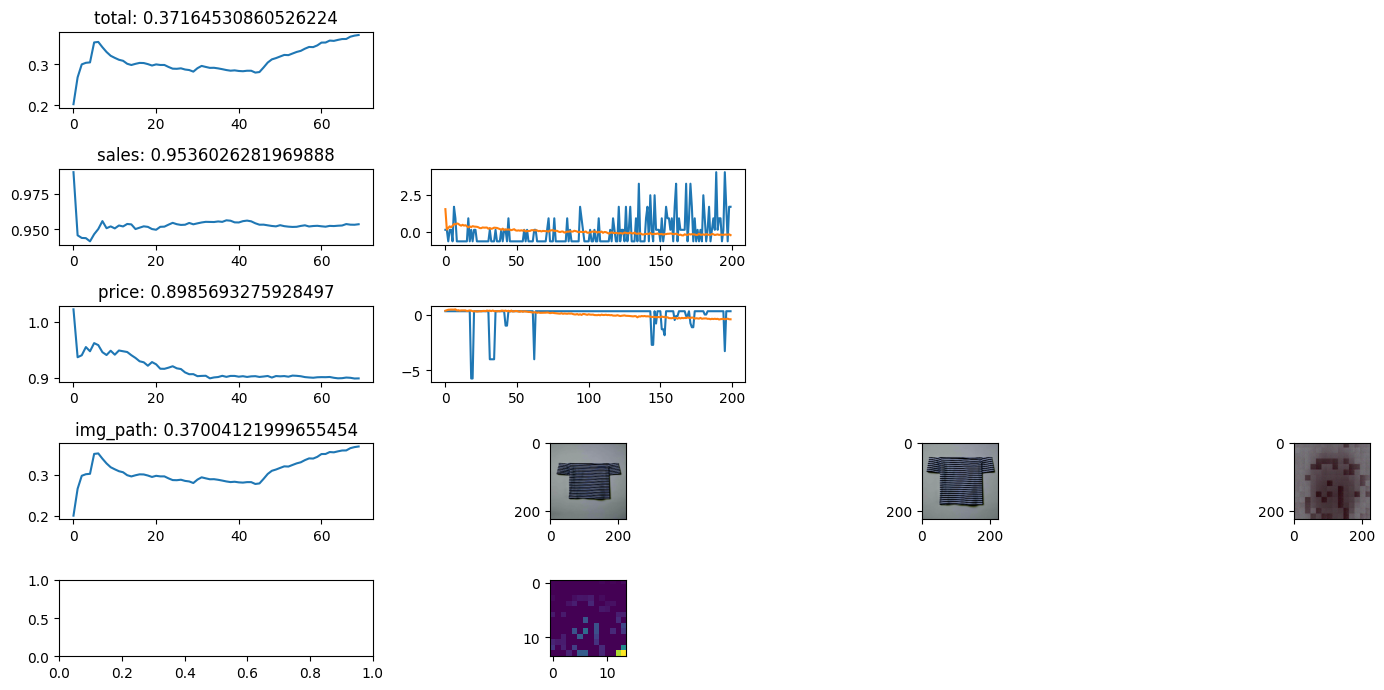

 97%|█████████▋| 1387/1429 [14:01<00:24,  1.72it/s]

In [12]:
import datetime

if mode == "pre-train":
    # Define model
    label_encoder_dict = joblib.load("./src/label_encoder_dict.pkl")
    model = MaskedBlockAutoEncoder(data_info, label_encoder_dict,
                            d_model, num_layers, nhead, d_ff, dropout, "gelu",
                            patch_size)
    model.to(device)
    # summary(model, data, remain_rto, device, show_parent_layers=True, print_summary=True)
    # for name, param in model.named_parameters():
    #     if "img_model" in name:
    #         param.requires_grad = False
    #     elif "nlp_model" in name:
    #         param.requires_grad = False

    # Train
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    epoch = 10
    epoch_loss = {}
    
    for e in range(epoch):
        loss = pre_train(e, model, train_dataloader, optimizer, data_info, patch_size)
        scheduler.step()
        epoch_loss[e] = loss

    print(epoch_loss)

# Test

In [ ]:
def plot_loss_sample(nrows, ncols, idx, mean_loss_li_dict, output_dict, data_dict, data, col_info, patch_size, cross_attn_weight_dict_dict, padding_mask_dict):
    plot_idx = 1
    for key, val in mean_loss_li_dict.items():
        # Individual loss
        plt.subplot(nrows, ncols, plot_idx)
        plt.plot(val)
        plt.title(f"{key}: {mean_loss_li_dict[key][-1]}")
        plot_idx += 1

        # Sample
        temporal_cols, img_cols, nlp_cols = col_info
        ### Temporal
        if key in temporal_cols:
            pred, y = output_dict[key].squeeze(), data_dict[key].squeeze()
            if key in data_info.processing_info["embedding_cols"]: pred = torch.argmax(pred, dim=-1)
            
            plt.subplot(nrows, ncols, plot_idx)
            plt.plot(y[idx].detach().cpu())
            plt.plot(pred[idx].detach().cpu())
        ### Img
        elif key in img_cols:
            pred, y = output_dict[key], data_dict[key]
            pred = unpatchify(pred[:, 1:, :], patch_size).permute(0,2,3,1)
            # pred = pred.permute(0,2,3,1)
            y = y.permute(0,2,3,1)

            plt.subplot(nrows, ncols, plot_idx)
            plt.imshow(data["img_path_raw"].permute(0,2,3,1)[idx])

            plt.subplot(nrows, ncols, plot_idx+1)
            plt.imshow(y[idx].detach().cpu())
            
            plt.subplot(nrows, ncols, plot_idx+2)
            plt.imshow(pred[idx].detach().cpu())
        
        plot_idx += 3

    cross_sales_weight = cross_attn_weight_dict_dict["sales"]["temporal"].squeeze().mean(dim=1)

    temporal_length = len(["global"] + data_info.modality_info["target"] + data_info.modality_info["temporal"])
    img_length = (224//patch_size)**2 + 1
    nlp_length = data_dict[data_info.modality_info["nlp"][0]].shape[-1] + data_dict[data_info.modality_info["nlp"][1]].shape[-1]
    assert temporal_length + img_length + nlp_length == cross_sales_weight.shape[-1], f"{temporal_length} + {img_length} + {nlp_length} == {cross_sales_weight.shape}"

    mask = padding_mask_dict["temporal_padding_mask"]
    img_attn_weight = cross_sales_weight[:, :, temporal_length:temporal_length+img_length]
    img_attn_weight = torch.where(mask.unsqueeze(-1).repeat(1, 1, img_attn_weight.shape[-1])==1, img_attn_weight, torch.nan)
    img_attn_weight = img_attn_weight[idx]
    img_attn_weight = img_attn_weight[~torch.isnan(img_attn_weight)].reshape(-1, img_attn_weight.shape[-1])

    img_attn_weight_seq_mean = img_attn_weight[0][1:]
    plt.subplot(nrows, ncols, plot_idx); plot_idx += 1
    img_attn_weight_seq_mean = img_attn_weight_seq_mean.reshape(224//patch_size,224//patch_size)
    
    plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(img_attn_weight_seq_mean.detach().cpu())
        
    plt.tight_layout()        
    plt.show()

def pre_train(e, model, data_loader, optimizer, data_info, patch_size):
    pbar = tqdm(data_loader)
    loss_li_dict, mean_loss_li_dict = defaultdict(list), defaultdict(list)
    accm_idx = 0
    
    model.eval()
    for n, data in enumerate(pbar):
        accm_idx += 1
        with torch.no_grad():
            output_dict, data_dict, idx_dict, padding_mask_dict, cross_attn_weight_dict_dict = model(data, remain_rto, device)

        col_info = model.define_col_modalities(data_info)
        loss_dict, total_loss = get_loss(output_dict, data_dict, data, idx_dict, padding_mask_dict, col_info, data_info, device)
        # total_loss = torch.stack(list(loss_dict.values())).sum()
        total_loss /= accm_idx

        # Plot
        if n % 20 == 0:
            nrows, ncols, idx = 11, 4, 0
            plt.figure(figsize=(15,15))
            clear_output(wait=True)
            
            loss_li_dict, mean_loss_li_dict = obtain_loss_dict_for_plot(total_loss, loss_dict, loss_li_dict, mean_loss_li_dict)
            plot_loss_sample(nrows, ncols, idx, mean_loss_li_dict, output_dict, data_dict, data, col_info, patch_size, cross_attn_weight_dict_dict, padding_mask_dict)
        
    # Save model
    if not is_test_mode:
        now = datetime.datetime.now()
        path = f"./saved_model_epoch{e}_{now}"
        torch.save(model.state_dict(), path)
        
    return mean_loss_li_dict["total"][-1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


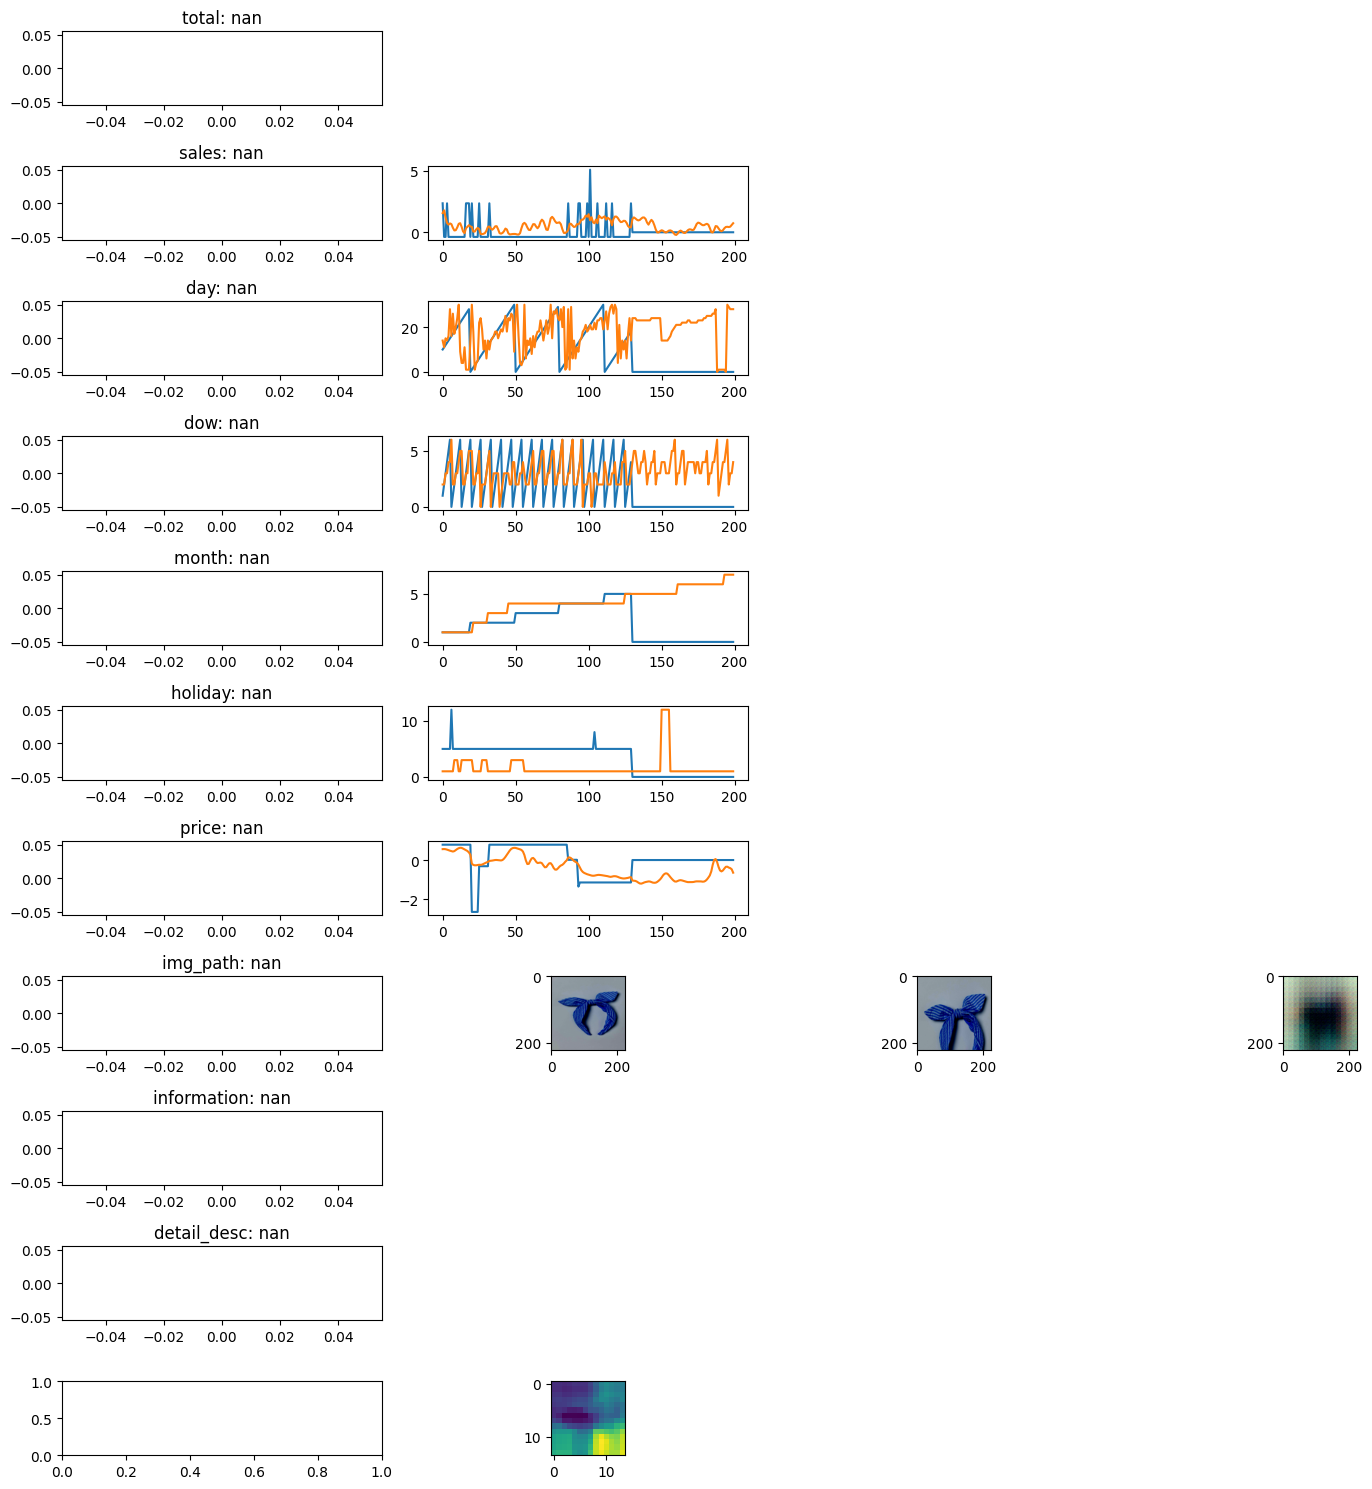

In [ ]:
import datetime

if mode == "pre-train":
    # Define model
    label_encoder_dict = joblib.load("./src/label_encoder_dict.pkl")
    model = MaskedBlockAutoEncoder(data_info, label_encoder_dict,
                            d_model, num_layers, nhead, d_ff, dropout, "gelu",
                            patch_size)
    model.load_state_dict(torch.load("saved_model_epoch0_2024-05-05 23:46:13.439997"))
    model.to(device)
    # summary(model, data, remain_rto, device, show_parent_layers=True, print_summary=True)
    # for name, param in model.named_parameters():
    #     if "img_model" in name:
    #         param.requires_grad = False
    #     elif "nlp_model" in name:
    #         param.requires_grad = False

    # Train
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    epoch = 10
    epoch_loss = {}
    
    for e in range(epoch):
        loss = pre_train(e, model, train_dataloader, optimizer, data_info, patch_size)
        scheduler.step()
        epoch_loss[e] = loss

    print(epoch_loss)